In [1]:
# Supressing the warning messages
import warnings
warnings.filterwarnings('ignore')

# will make plot outputs appear and be stored within the notebook
%matplotlib inline

# import libaries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import datetime
from datetime import datetime, timedelta
import geopandas as gpd
from shapely.geometry import Point, Polygon
import contextily as ctx
import math
import matplotlib as mpl

from sklearn.linear_model import LinearRegression
from sklearn import neighbors
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

# Helper functions

In [26]:
# Data Preparation Function 
def correct_data_types(chicagobikes):
  
    #Converting start-time to datetime
    chicagobikes['start'] = pd.to_datetime(chicagobikes['start_time']).dt.floor('min')
    #Converting end-time to datetime
    chicagobikes['end'] = pd.to_datetime(chicagobikes['end_time']).dt.floor('min')
    
   
    # rounding start time
    chicagobikes['time_rounded'] = chicagobikes['start'].dt.floor('H')
    
    # The day of the week with Monday=0, Sunday=6, week of year, month, day of month, hour of day
    chicagobikes['weekday'] = chicagobikes['time_rounded'].dt.weekday
    chicagobikes['week'] = chicagobikes['time_rounded'].dt.week
    chicagobikes['month'] = chicagobikes['time_rounded'].dt.month
    chicagobikes['day_of_month'] = chicagobikes['time_rounded'].dt.day
    chicagobikes['hour_of_day'] = chicagobikes['time_rounded'].dt.hour
  
    #trip duration
    chicagobikes['trip_duration'] = chicagobikes['end'] - chicagobikes['start']
    chicagobikes['trip_duration_minutes'] = chicagobikes['trip_duration'].dt.total_seconds()/60
    
    # date
    chicagobikes['date'] = chicagobikes['time_rounded'].dt.date
    
    return chicagobikes

In [46]:
# Source: self-written in last semester
def moving_average(array,n):
    target = []
    rng = n / 2 - 0.5
    rng = int(rng)
    i = 0
    while i < len(array):
        value = 0
        if (i >= rng-1) & (i< len(array)-rng):
            value = sum(array[i-rng:i+rng+1])/n
        target.append(value)
        i = i + 1
    i = 0
    while i < rng:
        target[i] = target[rng]
        target[-i-1] = target[-rng-1]
        i = i + 1
        
    return target

# 1. Data collection and preparation

Following steps will be done:
- Import data
- convert start/end time to datetime datatype
- adding additional columns for analysis

In [17]:
chicago_2017 = pd.read_csv('../chicago_2017.csv')

In [27]:
chicago_data = correct_data_types(chicago_2017)

As there are trips with same start and end station we assume that this orders are misorders. Let's remove them.

In [28]:
chicago_data = chicago_data[chicago_data['start_station_id'] != chicago_data['end_station_id']]

In [157]:
# calculate trips per hour
chicago_data['trips_per_hour']= chicago_data.groupby(['time_rounded'])['time_rounded'].transform('count')

In [164]:
def fleet_size(df,factor):
    
    start_date = df.date.min()
    end_date = df.date.max()
    delta = pd.to_timedelta("1d")
    dates = []
    while start_date <= end_date:
        dates.append(start_date)
        start_date += delta
    
    
    fleet_size = pd.DataFrame([], index = dates, columns = ["fleet_size"]) 

    search_array = []
    values = []
    for index, row in fleet_size.iterrows():
        search_array.append(index)
        if len(search_array) > factor:
            search_array.pop(0)
        values.append(df[df["date"].isin(search_array[:])].bike_id.nunique())
        
    i = 0
    
    #Erklärung hierfür
    correction = values[factor-1]
    while i < factor-1:
        values[i] = correction
        i = i + 1
    fleet_size["fleet_size"] = values
    
    return fleet_size

fleet_size = fleet_size(chicago_data,10)

# 2. Descriptive analytics

## 2.1 Temporal demand patterns / saisonality

In [158]:
durat = chicago_data[['trip_duration', 'time_rounded', 'user_type']]
durat['time_rounded'] = durat['time_rounded'].dt.hour
durat['trip_duration'] = durat['trip_duration'].dt.seconds.div(60)

In [159]:
# Create additional dataframe
# drop rows with identical time_rounded values for next step, so we have 1 representative row per hour
filtered_df = chicago_data.drop_duplicates(subset='time_rounded')

#Let's look for missing hourly data
filtered_df.sort_values(by=['time_rounded'], inplace=True)
filtered_df = filtered_df.set_index('time_rounded')

#Lets show missing hourly values
filtered_times = pd.date_range(start = filtered_df.index.min(), end = filtered_df.index.max(), freq='H')

filtered_times.difference(filtered_df.index)
#reindex and reset
filtered_df = filtered_df.reindex(filtered_times).reset_index()
#rename
filtered_df.rename(columns={'index': 'time_rounded'}, inplace=True)

#Let's impute missing hours, unforunately we cannot impute start station etc., so we use imputed data only for regression later on

#we assume 0 rides in those hours
filtered_df['trips_per_hour'].fillna(value=0, inplace=True) 
#other columns
filtered_df['weekday'].fillna(method="ffill", inplace=True) 
filtered_df['week'].fillna(method="ffill", inplace=True) 
filtered_df['day_of_month'].fillna(method="ffill", inplace=True) 
filtered_df['hour_of_day'].fillna(method="ffill", inplace=True) 
filtered_df['month'].fillna(method="ffill", inplace=True)

#### Daily demand patterns
In a first step we will check the daily demand patterns.

##### 1. Average trip length per hour

Text(0, 0.5, 'mean trip duration (in minutes)')

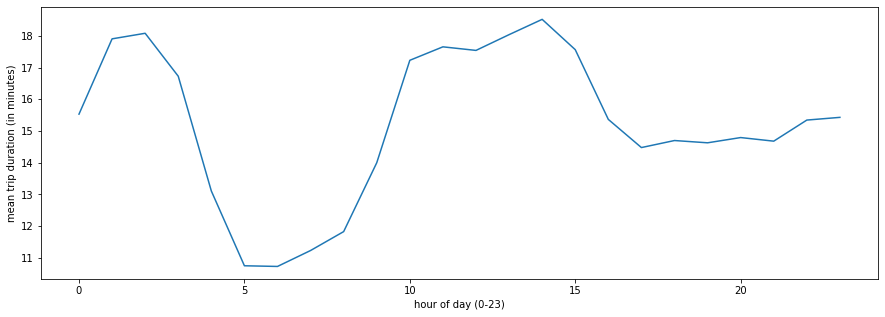

In [155]:
durat_daily = durat.groupby('time_rounded').agg(mean_durat=('trip_duration', 'mean'))

plt.figure(figsize=(15,5))
plt.plot(durat_daily)
plt.xlabel('hour of day (0-23)')
plt.ylabel('mean trip duration (in minutes)')

##### 2. Average amount trips per hour of day

Text(0, 0.5, 'mean amount of trips')

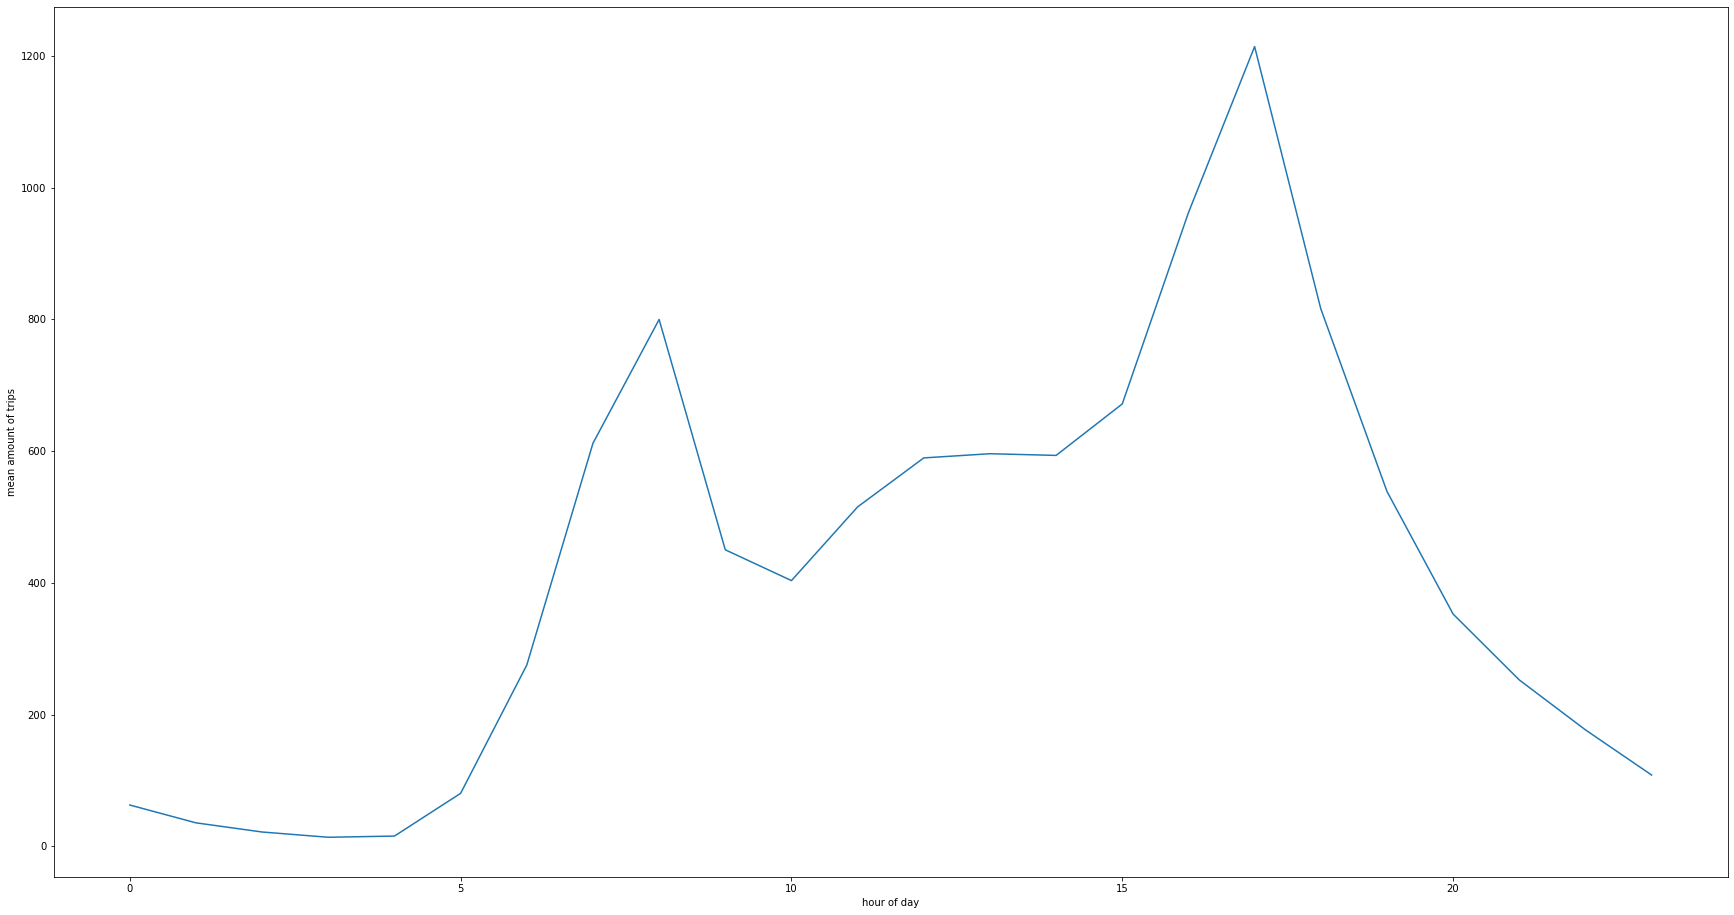

In [160]:
trips_hourofday = filtered_df.groupby('hour_of_day').agg(trips=('trips_per_hour','mean'))
plt.figure(figsize=(30,16))
plt.plot(trips_hourofday)
plt.xlabel('hour of day')
plt.ylabel('mean amount of trips')

#### Weekly patterns

Text(0, 0.5, 'average amount of trips')

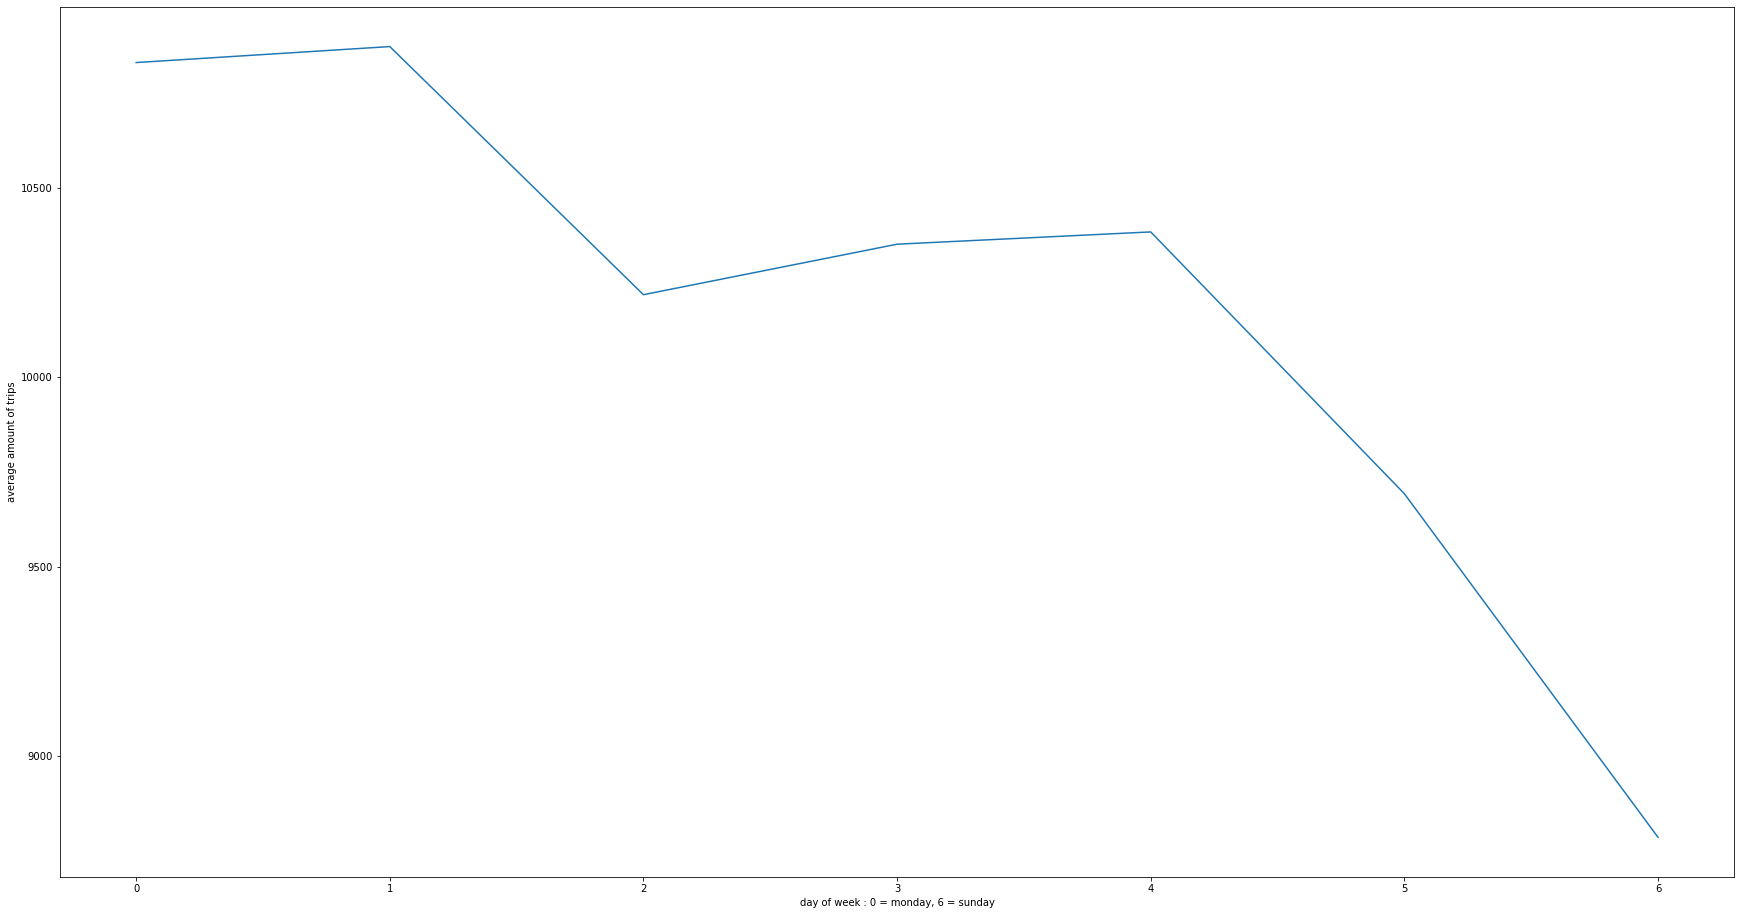

In [163]:
# average trips per day of week
daily = filtered_df.groupby('date').agg(daily_trips=("trips_per_hour","sum"))

# find weekday
daily = daily.reset_index()
daily['datetime'] = pd.to_datetime(daily['date'])
daily['weekday'] = daily['datetime'].dt.weekday
daily['week'] = daily['datetime'].dt.week

#plot amount of trips per weekday
day_of_week = daily.groupby('weekday').agg(weekday_trips = ("daily_trips","mean"))

plt.figure(figsize=(30,16))
plt.plot(day_of_week)
plt.xlabel('day of week : 0 = monday, 6 = sunday')
plt.ylabel('average amount of trips')

#### Seasonal patterns

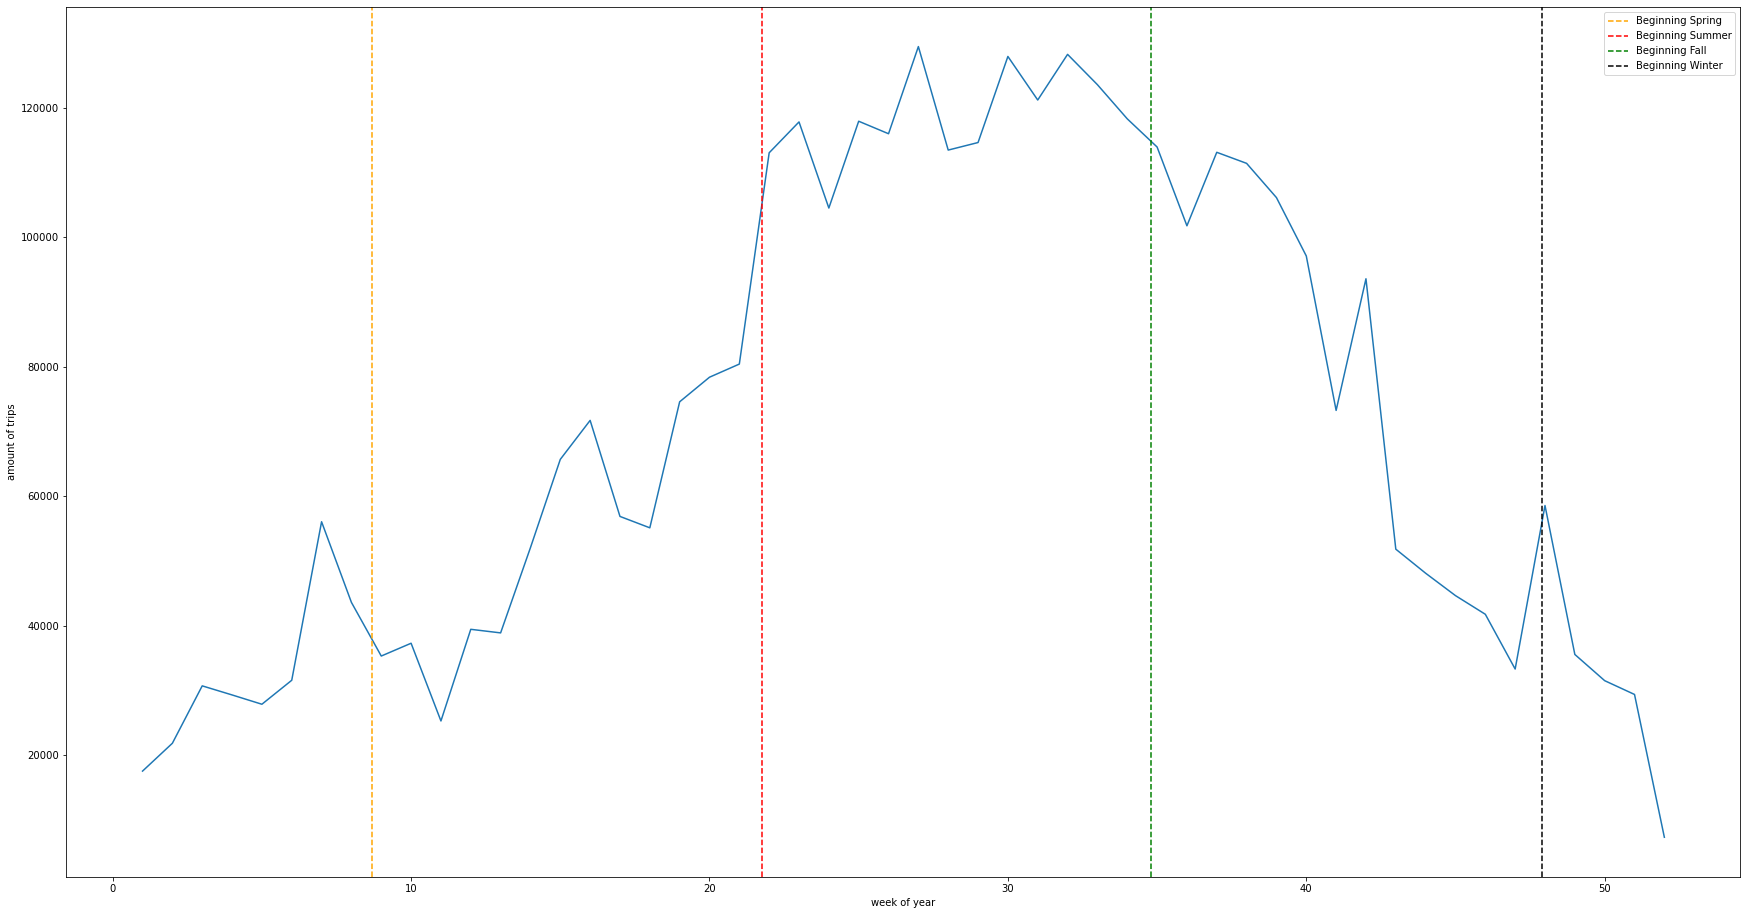

In [165]:
# create weekly df for simplification
weekly = daily.groupby('week').agg(week_total_trips = ("daily_trips", "sum"))

plt.figure(figsize=(30,16))
plt.plot(weekly)

#add season marker (northern hemnisphere), Meteorological Start approximately by calendar week, to provide orientation
plt.axvline(x = 8.7, label = 'Beginning Spring', color = 'orange', linestyle = '--')
plt.axvline(x = 21.75, label = 'Beginning Summer', color = 'red', linestyle = '--')
plt.axvline(x = 34.8, label = 'Beginning Fall', color = 'green', linestyle = '--')
plt.axvline(x = 47.9, label = 'Beginning Winter', color = 'black', linestyle = '--')

plt.xlabel('week of year')
plt.ylabel('amount of trips')
plt.legend(prop = {'size':10})

## 2.2 Geographical demand patterns

## 2.3 KPIs

##### KPI1 => Average trip duration per day
Our first KPI is the average trip duration per day as we assume that this will differ in the year

Text(0.5, 0.98, 'trip duration per day (mean)')

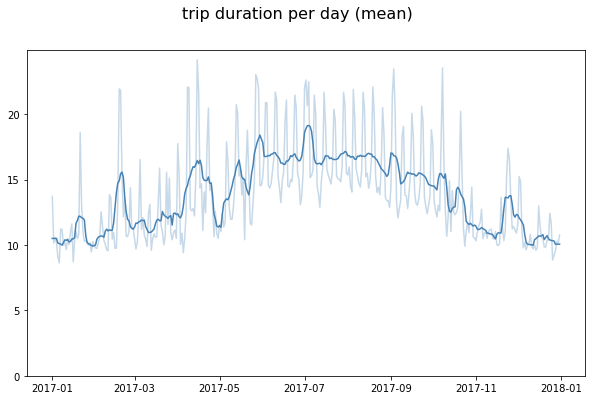

In [90]:
kpi_01 = chicago_data.groupby(['date']).agg(
        rental_count=("start_time","count"),
        mean_trip_duration=("trip_duration_minutes","mean")
)

kpi_01['mean_trip_duration_ma'] = moving_average(kpi_01["mean_trip_duration"],7)
kpi_01['rental_count_ma'] = moving_average(kpi_01["rental_count"],7)
kpi_01['customer_type_ma'] = moving_average(kpi_01["customer_type"],7)

fig,axis = plt.subplots(1,1,figsize=(10,6))

axis.plot(kpi_01.index, kpi_01['mean_trip_duration'],c="steelblue",alpha = 0.3)
axis.plot(kpi_01.index, kpi_01['mean_trip_duration_ma'],c="steelblue")

axis.set_ylim(bottom=0)
fig.suptitle("trip duration per day (mean)", fontsize=16)

#### KPI2 => Rentals per day 

Text(0.5, 0.98, 'Rentals per day')

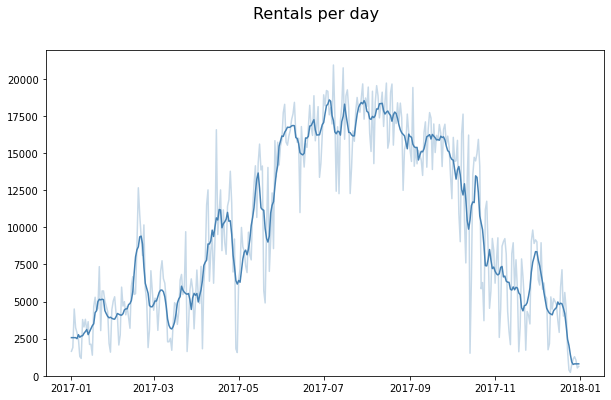

In [87]:
fig,axis = plt.subplots(1,1,figsize=(10,6))

axis.plot(kpi_01.index, kpi_01['rental_count'],c="steelblue",alpha = 0.3)
axis.plot(kpi_01.index, kpi_01['rental_count_ma'],c="steelblue")

axis.set_ylim(bottom=0)
fig.suptitle("Rentals per day", fontsize=16)

#### KPI3 => total rentals per station
As fleet manager we want to know which stations creates the most revenue.

Text(0.5, 0.98, 'total rentals per station')

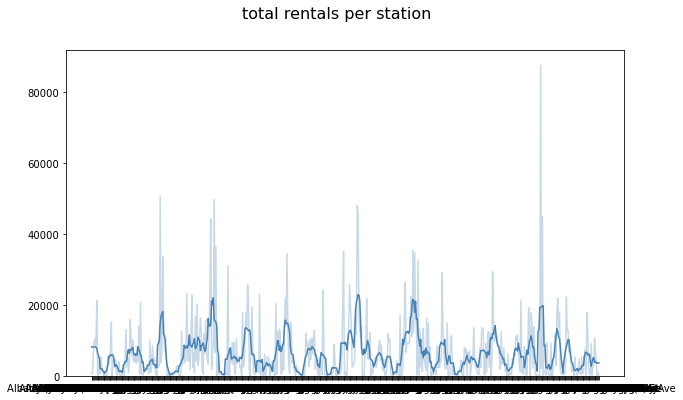

In [85]:
kpi_02 = chicago_data.groupby(['start_station_name']).agg(
        rental_count=("start_time","count")
)

kpi_02['rental_count_ma'] = moving_average(kpi_02["rental_count"],7)

fig,axis = plt.subplots(1,1,figsize=(10,6))

axis.plot(kpi_02.index, kpi_02['rental_count'],c="steelblue",alpha = 0.3)
axis.plot(kpi_02.index, kpi_02['rental_count_ma'],c="steelblue")

axis.set_ylim(bottom=0)
fig.suptitle("total rentals per station", fontsize=16)

#### KPI4 => Available bikes in the fleet 

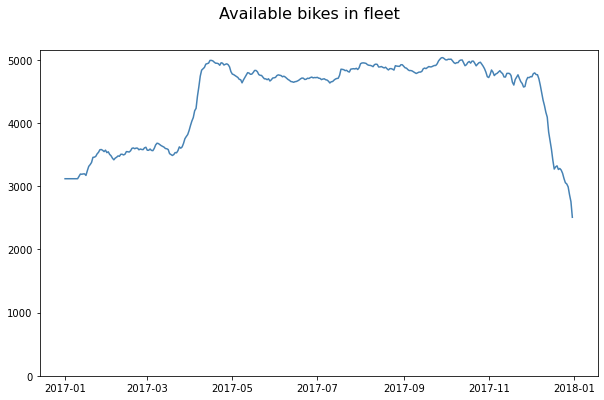

In [88]:
fig,axis = plt.subplots(1,1,figsize=(10,6))

_=axis.plot(fleet_size.index,(fleet_size["fleet_size"]),c="steelblue")

axis.set_ylim(bottom=0)
_=fig.suptitle("Available bikes in fleet", fontsize=16)

#### KPI5 => Customer types per day
As we have subscriber and customers as a renter type we want to know how much rentals will done per day from which renter type.

Text(0.5, 0.98, 'Customer types per day')

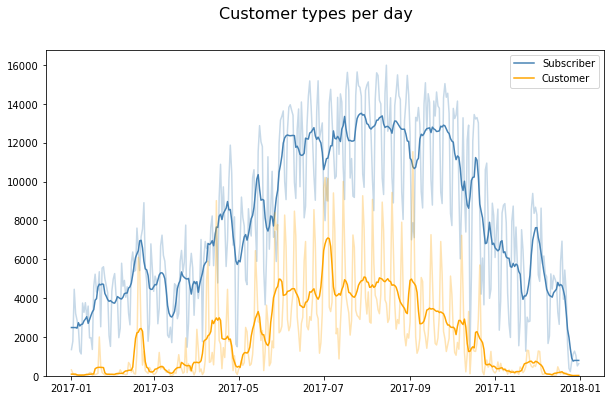

In [125]:
kpi_05_sub = chicago_data[chicago_data['user_type']=='Subscriber'].groupby(['date']).agg(
        rental_count=("start_time","count")
)
kpi_05_cus = chicago_data[chicago_data['user_type']=='Customer'].groupby(['date']).agg(
        rental_count=("start_time","count")
)

kpi_05_sub['rental_count_ma'] = moving_average(kpi_05_sub["rental_count"],7)
kpi_05_cus['rental_count_ma'] = moving_average(kpi_05_cus["rental_count"],7)

fig,axis = plt.subplots(1,1,figsize=(10,6))

axis.plot(kpi_05_sub.index, kpi_05_sub['rental_count'],c="steelblue",alpha = 0.3)
axis.plot(kpi_05_sub.index, kpi_05_sub['rental_count_ma'],c="steelblue", label="Subscriber")

axis.plot(kpi_05_cus.index, kpi_05_cus['rental_count'],c="orange",alpha = 0.3)
axis.plot(kpi_05_cus.index, kpi_05_cus['rental_count_ma'],c="orange", label="Customer")

axis.set_ylim(bottom=0)
axis.legend()
fig.suptitle("Customer types per day", fontsize=16)